## 准备数据集

In [4]:
from io import open
import glob
import string
import unicodedata
import os

In [5]:
all_letters=string.ascii_letters+".,;'-"
n_letters=len(all_letters)+1 # 加上eos

def findfiles(path):return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


def readLines(filename):
    with open(filename, encoding='utf-8') as file:
        return [unicodeToAscii(line.strip()) for line in file]
    
category_lines={}
all_categories=[]
for filename in findfiles('../data/names/*.txt'):
    category=os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines=readLines(filename)
    category_lines[category]=lines
    
n_categories=len(all_categories)

if n_categories==0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')
    
print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


## 构建神经网络

### 定义RNN模型

In [6]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

### 定义LSTM模型

In [27]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        embedded = self.embedding(input).view(1, 1, -1)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        output = self.fc(output[0])
        output = self.softmax(output)
        return output, hidden, cell

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

    def initCell(self):
        return torch.zeros(1, 1, self.hidden_size)

## 训练

In [18]:
import random

def randomChoice(l):
    return l[random.randint(0,len(l)-1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [20]:

def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor


def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor


def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [21]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [22]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [23]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [24]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 12s (5000 5%) 3.4613
0m 25s (10000 10%) 3.1202
0m 39s (15000 15%) 3.6684
0m 52s (20000 20%) 1.9960
1m 5s (25000 25%) 3.6744
1m 19s (30000 30%) 2.8963
1m 32s (35000 35%) 1.3052
1m 46s (40000 40%) 2.4902
2m 0s (45000 45%) 2.5763
2m 13s (50000 50%) 2.8533
2m 27s (55000 55%) 1.2091
2m 41s (60000 60%) 2.0646
2m 55s (65000 65%) 2.6594
3m 9s (70000 70%) 2.2038
3m 23s (75000 75%) 2.4218
3m 38s (80000 80%) 2.6174
3m 54s (85000 85%) 3.0012
4m 8s (90000 90%) 1.9059
4m 22s (95000 95%) 1.8655
4m 36s (100000 100%) 2.4926


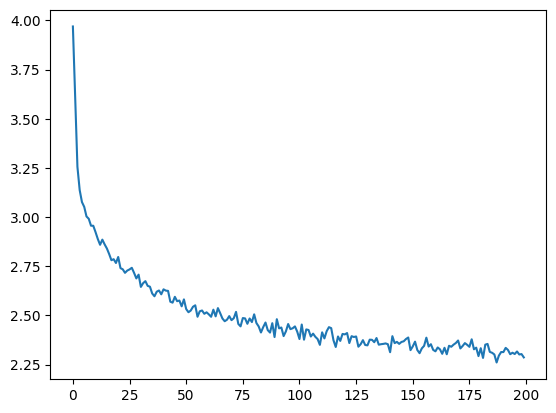

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [26]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rovakov
Uakovavovov
Shinovevivov
Gange
Eren
Roung
Santara
Parez
Allan
Chan
Ha
Iun
